In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
%pip install wandb
!wandb

Note: you may need to restart the kernel to use updated packages.
Usage: wandb [OPTIONS] COMMAND [ARGS]...

Options:
  --version  Show the version and exit.
  --help     Show this message and exit.

Commands:
  agent         Run the W&B agent
  artifact      Commands for interacting with artifacts
  controller    Run the W&B local sweep controller
  disabled      Disable W&B.
  docker        W&B docker lets you run your code in a docker image...
  docker-run    Simple wrapper for `docker run` which adds WANDB_API_KEY...
  enabled       Enable W&B.
  init          Configure a directory with Weights & Biases
  launch        Launch or queue a job from a uri (Experimental).
  launch-agent  Run a W&B launch agent (Experimental)
  local         Launch local W&B container (Experimental)
  login         Login to Weights & Biases
  offline       Disable W&B sync
  online        Enable W&B sync
  pull          Pull files from Weights & Biases
  restore       Restore code, config and docker state

In [26]:
%pip install kaggle --upgrade
import os
fpath = os.path.join(os.path.expanduser("~"), ".kaggle", "kaggle.json")
if not os.path.isfile(fpath):
    try:
        os.mkdir(os.path.join(os.path.expanduser("~"), ".kaggle"))
    except Exception:
        pass
    with open(fpath, "w") as f:
        f.write(input(f"input {fpath}"))
    !chmod 600 {fpath}

Note: you may need to restart the kernel to use updated packages.


In [27]:
if 'datasets' not in os.listdir(os.getcwd()) or 'animals10' not in os.listdir(os.path.join(os.getcwd(), 'datasets')):
    !kaggle datasets download alessiocorrado99/animals10
    !mkdir datasets
    !unzip animals10.zip -d datasets/animals10
    !rm animals10.zip

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class someNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(IM_HEIGHT*IM_WIDTH*3, 500)
        self.l2 = nn.Linear(500, 10)
    def forward(self, x):
        x = self.l1(x)
        x = F.relu(x)
        x = self.l2(x)
        x = F.log_softmax(x)
        return x


In [29]:
from tqdm import tqdm
def train(model, dev, train_set_loader, test_set_loader, optimizer, epoch, WAND, LOG_INTERVAL, VAL_INTERVAL):
    model.train()
    for bI, (x_b, y_b) in enumerate(tqdm(train_set_loader)):
        x_b, y_b = preprocess(x_b, y_b)
        pred = model.forward(x_b)
        loss = loss_fn(pred, y_b)
        # clear gradients for this training step
        optimizer.zero_grad()
        # backprop, compute gradients
        loss.backward()
        # apply gradients
        optimizer.step()
        print(f"loss: {loss}")
        if bI % LOG_INTERVAL == 0:
            loss_final = (loss/x_b.shape[0])
            if WAND: wandb.log({"train_loss": loss_final})
            print(bI,loss_final)
        if bI % VAL_INTERVAL == 0:
            test(model, dev, test_set_loader, WAND)

def test(model, dev, test_set_loader, WAND):
    with torch.no_grad():
        val_loss = torch.Tensor(len(test_set_loader)).to(dev)
        for i, (x_v_b, y_v_b) in enumerate(tqdm(test_set_loader)):
            x_v_b, y_v_b = preprocess(x_v_b, y_v_b)
            pred = model.forward(x_v_b)
            top_1_pred = torch.argmax(pred)
            top_1_accuracy = (top_1_pred == y_v_b).sum()/y_v_b.shape[0]
            loss = loss_fn(pred, y_v_b)
            if WAND:
                loss_final = loss/y_v_b.shape[0]
                wandb.log({"test_loss": loss_final})
                wandb.log({"top_1_accuracy": top_1_accuracy})
            print(f"i: {i}, loss_final: {loss_final}, top_1_acc: {top_1_accuracy}")


In [30]:
WAND = False
LOG_INTERVAL = 1
N_EPOCH = 1
LR = 0.001
BS = 64
VAL_INTERVAL = int(torch.ceil(torch.tensor((25_000*0.75)/(BS*10))).item())
print(VAL_INTERVAL)
IM_HEIGHT = 256
IM_WIDTH = 256
TRAIN_DAT_PERC = 0.75

30


In [31]:
if WAND:
  import wandb
  wandb_run = wandb.init(project="animals10", entity="0xasim")
  wandb.config = {
    "learning_rate": LR,
    "epochs": N_EPOCH,
    "batch_size": BS,
  }
  run_name = wandb_run.name

In [32]:
import torch
import os
# torch.manual_seed(17)
from torchvision import datasets, transforms
transform = transforms.Compose([transforms.Resize([IM_HEIGHT, IM_WIDTH]), transforms.ToTensor()])
path = os.path.join(os.getcwd(), "datasets", "animals10", "raw-img")
dataset = datasets.ImageFolder(path, transform=transform)
train_set, test_set = torch.utils.data.random_split(dataset, [int(len(dataset)*TRAIN_DAT_PERC), int(len(dataset)*round(1-TRAIN_DAT_PERC, 2))+1])
train_set_loader = torch.utils.data.DataLoader(train_set, batch_size=BS, shuffle=True)
test_set_loader = torch.utils.data.DataLoader(test_set, batch_size=BS, shuffle=True)

torch.Size([64, 3, 256, 256]) torch.Size([3, 256, 256])
tensor([[0.4275, 0.4078, 0.4118,  ..., 0.3412, 0.2784, 0.2588],
        [0.4431, 0.4275, 0.4275,  ..., 0.2902, 0.2431, 0.2353],
        [0.3843, 0.3725, 0.3843,  ..., 0.2000, 0.1686, 0.1725],
        ...,
        [0.3373, 0.2824, 0.2588,  ..., 0.2039, 0.2078, 0.2314],
        [0.2471, 0.1804, 0.1608,  ..., 0.1961, 0.1961, 0.2196],
        [0.2745, 0.1882, 0.1686,  ..., 0.1961, 0.1961, 0.2353]])


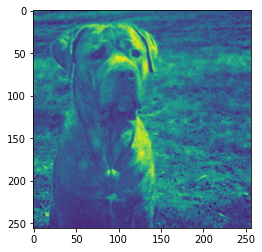

tensor([[0.8353, 0.8157, 0.8118,  ..., 0.7098, 0.6510, 0.6314],
        [0.8118, 0.7961, 0.7922,  ..., 0.6353, 0.5882, 0.5843],
        [0.6980, 0.6863, 0.6980,  ..., 0.5020, 0.4745, 0.4784],
        ...,
        [0.3647, 0.3333, 0.3412,  ..., 0.2784, 0.2784, 0.2980],
        [0.2392, 0.1922, 0.2039,  ..., 0.2627, 0.2588, 0.2824],
        [0.2392, 0.1725, 0.1843,  ..., 0.2588, 0.2588, 0.2980]])
tensor(0.1137)
tensor(1.)


In [33]:

import matplotlib.pyplot as plt
i, l = next(iter(train_set_loader))
print(i.shape, i[0].shape)
sample = i[0][2]
print(sample)
plt.imshow(i[0][2].reshape(IM_HEIGHT, IM_WIDTH))
plt.show()
print(i[0][0])
print(torch.min(i[0][0]))
print(torch.max(i[0][0]))

In [34]:
def preprocess(x, y):
    return x.view(len(x), -1).to(dev), y.to(dev)

if __name__ == '__main__':
    dev = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    print(dev)
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    model = someNet()
    model.to(dev)
    loss_fn = nn.CrossEntropyLoss().to(dev)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    for epoch in range(N_EPOCH):
        train(model, dev, train_set_loader, test_set_loader, optimizer, epoch, WAND, LOG_INTERVAL, VAL_INTERVAL)


cpu


  0%|          | 0/307 [00:00<?, ?it/s]/var/folders/c4/j059kg7n61q9x8b27zrclg8c0000gn/T/ipykernel_50614/2035250063.py:13: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


loss: 2.33400821685791
0 tensor(0.0365, grad_fn=<DivBackward0>)


UnboundLocalError: local variable 'loss_final' referenced before assignment

In [ ]:
test(model, dev, test_set_loader, WAND)

In [ ]:
model_name = run_name+'.pt'
MODEL_PATH = os.path.join(os.getcwd(), str(N_EPOCH))
torch.save(model.state_dict(), model_name)
print(model_name)
!ls -lah {model_name}

In [ ]:
INCOLAB = 'google.colab' in str(get_ipython()) if hasattr(__builtins__,'__IPYTHON__') else False
DOWNLOAD = True
if INCOLAB and DOWNLOAD:
    from google.colab import files
    files.download(model_name)